## 4.1.6 재현 신경망(Recurrent Neural Network) 분류 모델

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

import os
import json

## 시각화

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## 학습 데이터 파일 로드

In [ ]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

In [ ]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = None

with open(DATA_IN_PATH + DATA_CONFIGS, 'r') as f:
    prepro_configs = json.load(f)

## 모델 정의

In [ ]:
VOCAB_SIZE = prepro_configs['vocab_size']+1

BATCH_SIZE = 128
NUM_EPOCHS = 10
VALID_SPLIT = 0.1

In [ ]:
print(len(prepro_configs['vocab']), VOCAB_SIZE) #check the number of vocab

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          4740224   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,851,713
Trainable params: 4,851,713
Non-trainable params: 0
______________________________________________

In [8]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback])

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 78s 3ms/sample - loss: 0.6873 - accuracy: 0.5612 - val_loss: 0.5865 - val_accuracy: 0.7484
Epoch 2/10
22500/22500 [==============================] - 76s 3ms/sample - loss: 0.3898 - accuracy: 0.8404 - val_loss: 0.3139 - val_accuracy: 0.8712
Epoch 3/10
22500/22500 [==============================] - 78s 3ms/sample - loss: 0.2122 - accuracy: 0.9281 - val_loss: 0.2981 - val_accuracy: 0.8844
Epoch 4/10
22500/22500 [==============================] - 78s 3ms/sample - loss: 0.1361 - accuracy: 0.9604 - val_loss: 0.3281 - val_accuracy: 0.8884
Epoch 5/10
22500/22500 [==============================] - 77s 3ms/sample - loss: 0.0854 - accuracy: 0.9793 - val_loss: 0.3909 - val_accuracy: 0.8776


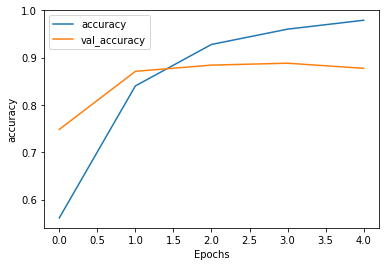

In [9]:
plot_graphs(history, 'accuracy')

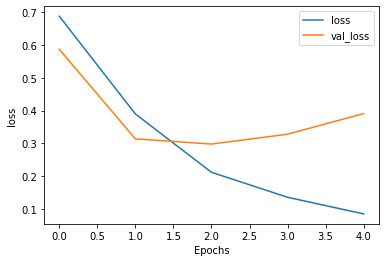

In [10]:
plot_graphs(history, 'loss')

## 캐글 평가 데이터셋 만들기 TODO

In [11]:
DATA_OUT_PATH = './data_out/'
TEST_INPUT_DATA = 'test_input.npy'
TEST_ID_DATA = 'test_id.npy'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])

In [12]:
test_loss, test_acc = model.evaluate(test_input_data)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

NameError: name 'test_input_data' is not defined

In [ ]:
predict_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x":test_input_data}, shuffle=False)

In [ ]:
predictions = np.array([p['sentiment'] for p in est.predict(input_fn=
predict_input_fn)])

In [ ]:
test_id = np.load(open(DATA_IN_PATH + TEST_ID_DATA, 'rb'))

In [ ]:
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

output = pd.DataFrame(data={"id": list(test_id), "sentiment":list(predictions)} )
output.to_csv(DATA_OUT_PATH + 'movie_review_result_rnn.csv', index=False, quoting=3 )